# Fine-tuning an Object Detection Model on the NA Birds Dataset  
[Link to dataset](https://dl.allaboutbirds.org/nabirds)  
NABirds V1 is a collection of 48,000 annotated photographs of the 400 species of birds that are commonly observed in North America. More than 100 photographs are available for each species, including separate annotations for males, females and juveniles that comprise 700 visual categories. This dataset is to be used for fine-grained visual categorization experiments. 

### Data Exploration

In [1]:
import os

In [2]:
proj_dir = os.path.join('/home/mark/git', 'birdcam')

data_dir = os.path.join('/media/nvme2', 'nabirds')

Image bounding boxes

In [3]:
bboxes = {}

with open(os.path.join(data_dir, 'bounding_boxes.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        image_id = pieces[0]
        bbox = list(map(int, pieces[1:]))
        bboxes[image_id] = bbox

In [4]:
bboxes['0004ff8d-0cc8-47ee-94ba-43352a8b9eb4']

[417, 109, 221, 467]

Image labels

In [5]:
labels = {}

with open(os.path.join(data_dir, 'image_class_labels.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        image_id = pieces[0]
        class_id = pieces[1]
        labels[image_id] = class_id

In [6]:
labels['0004ff8d-0cc8-47ee-94ba-43352a8b9eb4']

'951'

In [7]:
labels_int = [int(label) for label in list(labels.values())]

In [8]:
unique_labels = set(labels_int)

In [9]:
len(unique_labels)

555

In [10]:
min(unique_labels)

295

In [11]:
max(unique_labels)

1010

In [12]:
1010 - 295

715

Label names

In [13]:
names = {}

with open(os.path.join(data_dir, 'classes.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        class_id = pieces[0]
        names[class_id] = ' '.join(pieces[1:])

In [14]:
names['951']

'Florida Scrub-Jay'

Image paths

In [15]:
img_paths = {}

with open(os.path.join(data_dir, 'images.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        image_id = pieces[0]
        img_path = os.path.join(os.path.join(data_dir, f'images/{pieces[1]}'))
        img_paths[image_id] = img_path

In [16]:
img_paths['0004ff8d-0cc8-47ee-94ba-43352a8b9eb4']

'/media/nvme2/nabirds/images/0951/0004ff8d0cc847ee94ba43352a8b9eb4.jpg'

Image sizes

In [17]:
img_sizes = {}

with open(os.path.join(data_dir, 'sizes.txt')) as f:
    for line in f:
        pieces = line.strip().split()
        image_id = pieces[0]
        width, height = map(int, pieces[1:])
        img_sizes[image_id] = [width, height]

In [18]:
img_sizes['0004ff8d-0cc8-47ee-94ba-43352a8b9eb4']

[1024, 683]

### View sample image

In [19]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [20]:
img_id = '0004ff8d-0cc8-47ee-94ba-43352a8b9eb4'

img = plt.imread(img_paths[img_id])
bbox = bboxes[img_id]
label = labels[img_id]
name = names[label]

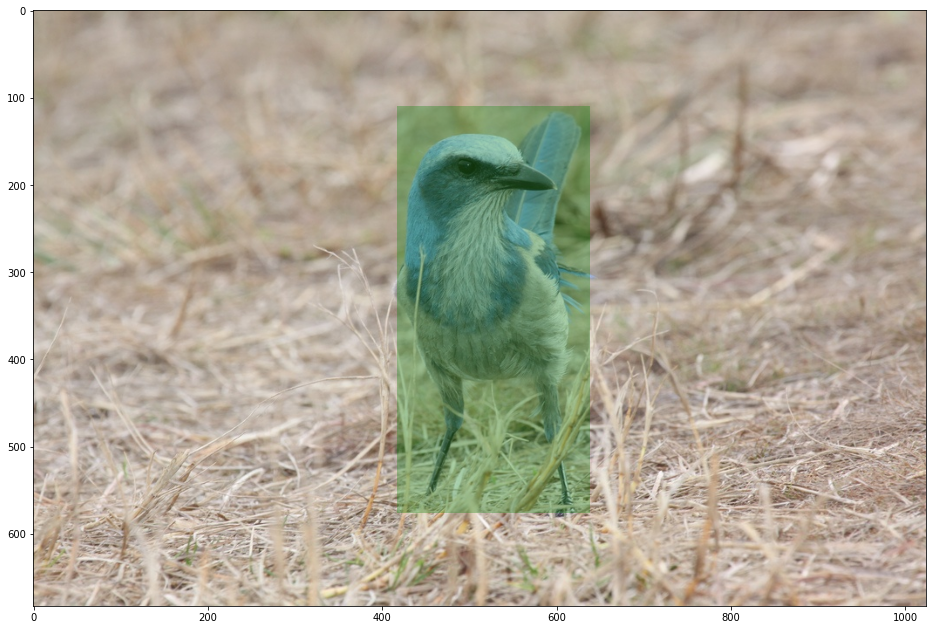

In [21]:
fig = plt.figure(1, figsize=(16, 12))
plt.imshow(img)

x, y, w, h = bbox
current_axis = plt.gca()
current_axis.add_patch(plt.Rectangle((x, y), w, h, facecolor='green', alpha=0.3))
plt.show()

##### View images of a specific species

In [22]:
for label, name in names.items():
    if 'Tufted' in name:
        print(label, name)

717 Tufted Titmouse
819 Tufted Titmouse


In [23]:
chickadee_label = '819'

In [24]:
chickadee_imgs = []

for img_id, label in labels.items():
    if label == chickadee_label:
        chickadee_imgs.append(img_id)

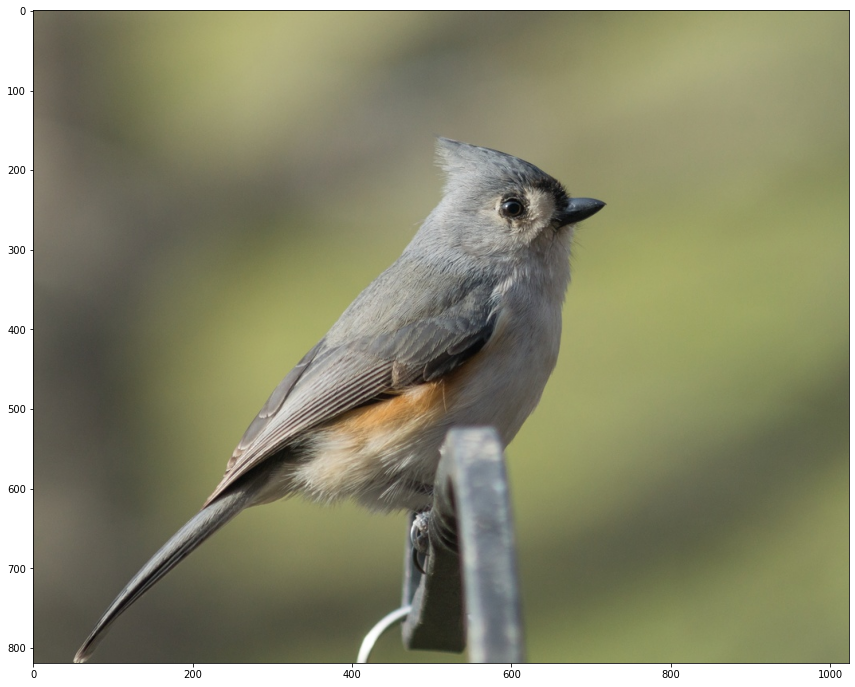

In [25]:
img_id = chickadee_imgs[11]

img = plt.imread(img_paths[img_id])

fig = plt.figure(1, figsize=(16, 12))
plt.imshow(img)
plt.show()

### Create custom dataset

In [26]:
import torch
from PIL import Image

In [27]:
class NABirdsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.imgs = []
        with open(os.path.join(root, 'images.txt')) as f:
            for line in f:
                pieces = line.strip().split()
                img_path = os.path.join(os.path.join(root, f'images/{pieces[1]}'))
                self.imgs.append(img_path)
                
        self.classes = {}
        with open(os.path.join(data_dir, 'classes.txt')) as f:
            for line in f:
                pieces = line.strip().split()
                class_id = int(pieces[0])
                self.classes[class_id] = ' '.join(pieces[1:])
        self.n_classes = len(self.classes)
        
        self.labels = []
        with open(os.path.join(root, 'image_class_labels.txt')) as f:
            for line in f:
                pieces = line.strip().split()
                self.labels.append(int(pieces[1]))
                
        self.bboxes = []
        with open(os.path.join(root, 'bounding_boxes.txt')) as f:
            for line in f:
                pieces = line.strip().split()
                bbox = list(map(int, pieces[1:]))
                bbox[2] = bbox[0] + bbox[2]
                bbox[3] = bbox[1] + bbox[3]
                self.bboxes.append(bbox)
                
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        box = torch.tensor(self.bboxes[idx], dtype=torch.float32)
        boxes = box[None, :]
        
        labels = torch.tensor([self.labels[idx]], dtype=torch.int64)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [28]:
na_birds_dataset = NABirdsDataset(root='/media/nvme2/nabirds')

In [29]:
na_birds_dataset[0]

(<PIL.Image.Image image mode=RGB size=296x341>,
 {'boxes': tensor([[ 83.,  59., 211., 287.]]),
  'labels': tensor([817]),
  'image_id': tensor([0]),
  'area': tensor([29184.]),
  'iscrowd': tensor([0])})

Show random sample of data

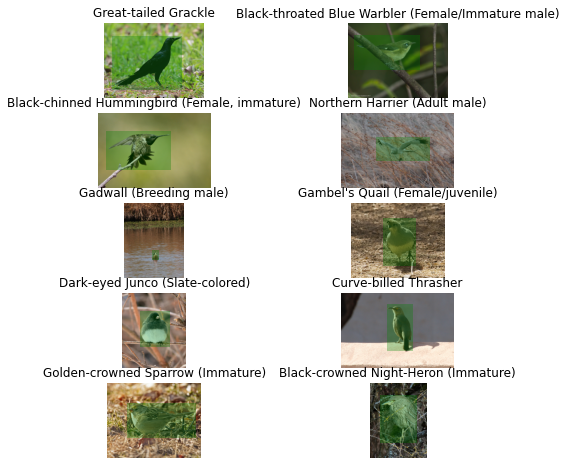

In [30]:
figure = plt.figure(figsize=(8, 8))
for i in range(1, 11):
    sample_idx = torch.randint(len(na_birds_dataset), size=(1,)).item()
    img, target = na_birds_dataset[sample_idx]
    label = target['labels']
    xmin, ymin, xmax, ymax = target['boxes'][0]
    width = xmax - xmin
    height = ymax - ymin
    figure.add_subplot(5, 2, i)
    plt.title(na_birds_dataset.classes[int(label[0])])
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(Rectangle((xmin,ymin), width, height, facecolor='green', alpha=0.3))
plt.show()

### Finetuning from a pretrained model

In [31]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Get pretrained model

In [32]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/home/mark/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mark/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Replace pretrained head with a new one that has the correct number of classes

In [33]:
num_classes = na_birds_dataset.n_classes - 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Train and evaluate
Single GPU

In [34]:
from birdcam.engine import train_one_epoch, evaluate
import birdcam.utils as utils
import birdcam.transforms as T

In [35]:
def get_transforms(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Test forward method

In [36]:
dataset = NABirdsDataset(
        root='/media/nvme2/nabirds', 
        transforms=get_transforms(train=True)
    )
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn
    )

images, targets = next(iter(data_loader))
images = [image for image in images]
targets = [{k: v for k, v in t.items()} for t in targets]
targets
# output = model(images, targets)
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

[{'boxes': tensor([[335., 103., 767., 578.]]),
  'labels': tensor([764]),
  'image_id': tensor([35090]),
  'area': tensor([205200.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[265., 138., 678., 495.]]),
  'labels': tensor([951]),
  'image_id': tensor([28523]),
  'area': tensor([147441.]),
  'iscrowd': tensor([0])}]

In [37]:
output = model(images, targets)

In [38]:
output

{'loss_classifier': tensor(6.4940, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1741, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0004, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0025, grad_fn=<DivBackward0>)}

In [39]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [40]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

Get datasets

In [41]:
dataset = NABirdsDataset(
        root='/media/nvme2/nabirds', 
        transforms=get_transforms(train=True)
    )
dataset_val = NABirdsDataset(
        root='/media/nvme2/nabirds', 
        transforms=get_transforms(train=False)
    )

In [42]:
len(dataset) * .2

9712.4

Train/test split

In [43]:
torch.manual_seed(77)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10000])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-10000:])

Get dataloaders

In [44]:
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=8, collate_fn=utils.collate_fn
    )
data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
    )

Get model

In [45]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = na_birds_dataset.n_classes
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Send model to GPU

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Get optimizer and learning rate scheduler

In [47]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Train and evaluate for 1 epoch

In [48]:
import datetime
import time

start_time = time.time()
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))

print('Total training time: {}'.format(total_time_str))

Epoch: [0]  [   0/9641]  eta: 8:18:56  lr: 0.000010  loss: 7.1572 (7.1572)  loss_classifier: 6.9486 (6.9486)  loss_box_reg: 0.2050 (0.2050)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 3.1052  data: 0.8354  max mem: 7347
Epoch: [0]  [1000/9641]  eta: 1:17:07  lr: 0.005000  loss: 0.5089 (0.6300)  loss_classifier: 0.3326 (0.4574)  loss_box_reg: 0.1724 (0.1669)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0035 (0.0043)  time: 0.5260  data: 0.0154  max mem: 8181
Epoch: [0]  [2000/9641]  eta: 1:08:29  lr: 0.005000  loss: 0.4486 (0.5569)  loss_classifier: 0.3055 (0.3895)  loss_box_reg: 0.1341 (0.1619)  loss_objectness: 0.0002 (0.0013)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 0.5468  data: 0.0149  max mem: 8181
Epoch: [0]  [3000/9641]  eta: 0:59:33  lr: 0.005000  loss: 0.4274 (0.5231)  loss_classifier: 0.3161 (0.3675)  loss_box_reg: 0.1084 (0.1502)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0042)  time: 0.5197  data: 0.0152  max me